# EMNIST Image Classification

## Test Cuda

In [1]:
import torch

In [2]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1060 6GB'

In [3]:
torch.cuda.device_count()

1

## Start MLFlow

In [4]:
get_ipython().system_raw("mlflow ui --port 5000 --host 0.0.0.0 &")

[2024-02-24 11:00:15 +0000] [8899] [INFO] Starting gunicorn 21.2.0
[2024-02-24 11:00:15 +0000] [8899] [INFO] Listening at: http://0.0.0.0:5000 (8899)
[2024-02-24 11:00:15 +0000] [8899] [INFO] Using worker: sync
[2024-02-24 11:00:15 +0000] [8900] [INFO] Booting worker with pid: 8900
[2024-02-24 11:00:15 +0000] [8901] [INFO] Booting worker with pid: 8901
[2024-02-24 11:00:15 +0000] [8902] [INFO] Booting worker with pid: 8902
[2024-02-24 11:00:15 +0000] [8903] [INFO] Booting worker with pid: 8903


## DNN PyTorch Model

In [80]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema, TensorSpec

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.functional import accuracy

In [6]:
BATCH_SIZE = 64
INPUT_SIZE = 28*28
OUTPUT_SIZE = 26

### Dataset

In [7]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
len(classes)

26

In [8]:
emnist_train_data = pd.read_csv("./datasets/emnist-letters-train.csv", header=None)

emnist_test_data = pd.read_csv("./datasets/emnist-letters-test.csv", header=None)
emnist_test_data = emnist_test_data.sample(frac=1)

In [9]:
emnist_train_data.head(5)
# 28x28=784 pixel grayscale images - 0-column = 26 labels for each letter of the alphabet

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
emnist_test_data.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
3612,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3820,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6736,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8176,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5293,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
emnist_train_data.describe()
# 88800 images with labels between 1-26

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,88800.000000,88800.0,88800.0,88800.0,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,...,88800.0,88800.0,88800.0,88800.000000,88800.000000,88800.0,88800.0,88800.0,88800.0,88800.0
mean,13.519268,0.0,0.0,0.0,0.000011,0.003986,0.016757,0.024640,0.021486,0.017140,...,0.0,0.0,0.0,0.003041,0.000360,0.0,0.0,0.0,0.0,0.0
std,7.502931,0.0,0.0,0.0,0.003356,0.544039,1.547686,1.915976,1.803270,1.620194,...,0.0,0.0,0.0,0.823445,0.107385,0.0,0.0,0.0,0.0,0.0
min,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,7.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,14.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,20.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,26.000000,0.0,0.0,0.0,1.000000,107.000000,213.000000,217.000000,214.000000,216.000000,...,0.0,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


In [12]:
# extract labels
train_labels = emnist_train_data.values[:, 0]
train_images = emnist_train_data.values[:, 1:]

In [13]:
# reshape image to the original 28x28 shape
train_images = train_images.reshape(-1, 28, 28)

In [14]:
sample_images = np.random.randint(0, len(train_images), 16)

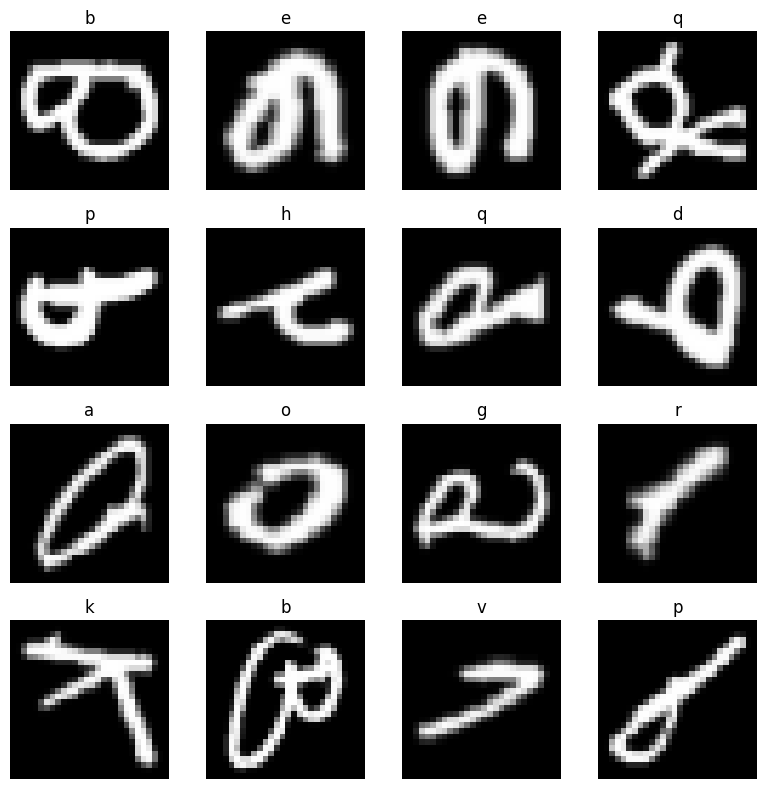

In [15]:
fig = plt.figure(figsize = (8, 8))

for i, idx in enumerate(sample_images):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_images[idx] / 255.0, cmap="gray")
    plt.title(classes[int(train_labels[idx] - 1)])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Create the MLFlow Experiment

In [16]:
experiment_name = "emnist_classifier_dnn"
mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///opt/app/notebooks/mlruns/188486067793059070', creation_time=1708772450020, experiment_id='188486067793059070', last_update_time=1708772450020, lifecycle_stage='active', name='emnist_classifier_dnn', tags={}>

In [17]:
experiment = mlflow.get_experiment_by_name(experiment_name)

print("Name: {}".format(experiment.name))
print("ID: {}".format(experiment.experiment_id))
print("Artifacts: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Stage: {}".format(experiment.lifecycle_stage))
print("Updated: {}".format(experiment.last_update_time))
print("Created: {}".format(experiment.creation_time))

Name: emnist_classifier_dnn
ID: 188486067793059070
Artifacts: file:///opt/app/notebooks/mlruns/188486067793059070
Tags: {}
Stage: active
Updated: 1708772450020
Created: 1708772450020


### MLFlow Run

In [18]:
dataset_info = """
The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19  and converted to a 28x28 pixel
image format and dataset structure that directly matches the MNIST dataset . Further information on the dataset contents and conversion
process can be found in the paper available at https://arxiv.org/abs/1702.05373v1
"""

with open("dataset_info.txt", "w") as f:
    f.write(dataset_info)

In [19]:
with mlflow.start_run(run_name = 'emnist_classifier_dnn_test_run') as current_run:
    mlflow.log_metric('Accuracy', 0.67)

    params = {
        'num_nn_layers': 4
    }
    
    mlflow.log_params(params)
    mlflow.log_figure(fig, 'sample_images.jpg')
    mlflow.log_artifact('dataset_info.txt')
    mlflow.set_tag('EMNIST', 'Character Classification')

### Train Test Split

In [20]:
class EMNISTDataset(Dataset):
    def __init__(self, dataframe):
        self.images = torch.tensor(dataframe.iloc[:, 1:].values, dtype=torch.float32)
        self.labels = torch.tensor(dataframe.iloc[:, 0].values, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        images = self.images[idx]
        images = images / 255.0
        labels = self.labels[idx]

        return images, labels

In [21]:
train_dataset = EMNISTDataset(emnist_train_data)
test_dataset = EMNISTDataset(emnist_test_data)

len(train_dataset), len(test_dataset)

(88800, 14800)

In [22]:
val_percent = 0.1
val_len = int(val_percent * len(train_dataset))

train, val = random_split(train_dataset, [len(train_dataset) - val_len, val_len])
print(len(train), len(val))

79920 8880


### Data Loaders

In [23]:
train_dl = DataLoader(train, BATCH_SIZE, shuffle=True, drop_last=True, num_workers=1)
val_dl = DataLoader(val, BATCH_SIZE, num_workers=1)
test_dl = DataLoader(test_dataset, BATCH_SIZE, num_workers=1)

print(len(train_dl), len(val_dl), len(test_dl))

1248 139 232


In [24]:
dataiter = iter(train_dl)
batch_images, batch_labels = next(dataiter)

print(batch_images.shape, len(batch_labels))
# each batch consists of 64 28x28=784 pixel images with 64 corresponding labels)

torch.Size([64, 784]) 64


## DNN Model Training

In [25]:
class EmnistModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()

        self.linear1 = nn.Linear(INPUT_SIZE, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 32)
        self.linear4 = nn.Linear(32, OUTPUT_SIZE)

    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)

        out = self.linear2(out)
        out = F.relu(out)

        out = self.linear3(out)
        out = F.relu(out)

        out = self.linear4(out)
        return out

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = 0.0001)

    def training_step(self, batch, batch_idx):
        # batches consists of images and labels
        x, y = batch
        # labels start at 1 but the classes at 0
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task="multiclass", num_classes=26)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim=1)

        acc = accuracy(pred, y, task="multiclass", num_classes=26)
        
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

        return acc

    def test_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim=1)

        acc = accuracy(pred, y, task="multiclass", num_classes=26)
        
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_epoch=True, prog_bar=True)

        return acc

    def predict_step(self, batch, batch_idx, dataloaders_idx=0):
        x, y = batch
        return self(x)

In [26]:
emnist_model = EmnistModel()
logger = CSVLogger("logs", name="emnist_classifier_dnn")
trainer = pl.Trainer(max_epochs = 10, logger=logger)
mlflow.pytorch.autolog(log_models = False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024/02/24 11:01:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


In [28]:
with mlflow.start_run() as run:
    trainer.fit(emnist_model, train_dl, val_dl)
    trainer.test(dataloaders = test_dl)

    input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 784))])
    output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 26))])

    signature = ModelSignature(inputs = input_schema, outputs = output_schema)

    mlflow.pytorch.log_model(emnist_model, "emnist_classifier_dnn", signature = signature)

# ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#        Test metric             DataLoader 0
# ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#         test_acc            0.8519594669342041
#         test_loss           0.4712047874927521
# ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

2024/02/24 11:01:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:356: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.4.9 and 2.1.3 and may not succeed with packages outside this range."
Missing logger folder: logs/emnist_classifier_dnn
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | linear1   | Linear           | 401 K 
2 | linear2   | Linear           | 65.7 K
3 | linear3   | Linear           | 4.1 K 
4 | linear4   | Linear           | 858   
-----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.890     Total estimated model params size (MB)


Sanity Checking: |                                                                            | 0/? [00:00<?, …

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                   | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

`Trainer.fit` stopped: `max_epochs=10` reached.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/emnist_classifier_dnn/version_0/checkpoints/epoch=9-step=12480.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/emnist_classifier_dnn/version_0/checkpoints/epoch=9-step=12480.ckpt
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performan

Testing: |                                                                                    | 0/? [00:00<?, …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8519594669342041
        test_loss           0.4712047874927521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## DNN Model Evaluation

In [32]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics

,epoch,step,test_acc,test_loss,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc,val_loss
0,0,49,NaN,NaN,NaN,0.093750,NaN,3.196841,NaN,NaN
1,0,99,NaN,NaN,NaN,0.203125,NaN,3.049770,NaN,NaN
2,0,149,NaN,NaN,NaN,0.312500,NaN,2.749519,NaN,NaN
3,0,199,NaN,NaN,NaN,0.312500,NaN,2.501953,NaN,NaN
4,0,249,NaN,NaN,NaN,0.421875,NaN,2.326618,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
265,9,12399,NaN,NaN,NaN,0.906250,NaN,0.315365,NaN,NaN
266,9,12449,NaN,NaN,NaN,0.875000,NaN,0.296436,NaN,NaN
267,9,12479,NaN,NaN,NaN,NaN,NaN,NaN,0.869369,0.427438
268,9,12479,NaN,NaN,0.878831,NaN,0.393668,NaN,NaN,NaN


<Axes: xlabel='epoch'>

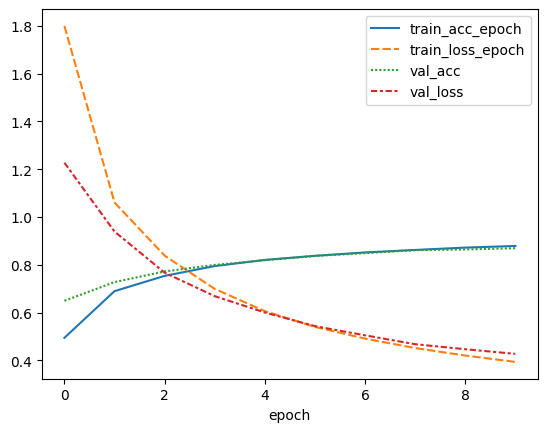

In [34]:
metrics.set_index("epoch", inplace=True)
metrics.drop(columns=['step', 'train_loss_step',
                      'train_acc_step', 'test_acc', 'test_loss'], inplace=True)
sns.lineplot(data=metrics)

### DNN Model Prediction

In [72]:
run_id = mlflow.last_active_run().info.run_id

In [73]:
# get a test batch of images
test_dataiter = iter(test_dl)
test_images, test_labels = next(test_dataiter)
test_images.shape, test_labels.shape

(torch.Size([64, 784]), torch.Size([64]))

In [74]:
model_path = f"runs:/{run_id}/emnist_classifier_dnn"
loaded_model = mlflow.pyfunc.load_model(model_path)

In [76]:
predictions = loaded_model.predict(test_images.numpy())
predictions[:1]
# returns prediction probabilities for all 26 classes for the first image

array([[ -1.6826886 ,  10.770611  ,  -5.4036117 ,   5.1765246 ,
         -2.6077387 ,  -1.9200826 ,   2.373778  ,   5.2585273 ,
          0.3091326 ,  -0.64922315,   2.50735   ,   1.5971591 ,
        -13.177171  ,  -4.226968  ,  -5.1098003 ,  -4.3791833 ,
          2.1347053 ,  -1.708756  ,   2.6252825 ,  -1.729482  ,
         -3.1101046 ,  -4.089718  ,   0.18128592,   2.6147778 ,
         -1.7666149 ,  -1.339035  ]], dtype=float32)

In [77]:
# get true label of the test image at position 0
print("Class Index:", int(test_labels[0].item() - 1))
print("Class:", classes[int(test_labels[0].item()) - 1])

Class Index: 1
Class: b


In [78]:
# get predicted label of the test image at position 0
print("Class Index:", np.argmax(predictions[0]))
print("Class:", classes[np.argmax(predictions[0])])

Class Index: 1
Class: b


In [79]:
# reshape image to the original 28x28 shape
# test_images_reshaped = test_images.reshape(-1, 28, 28)
test_samples = np.random.randint(0, len(test_images), 16)

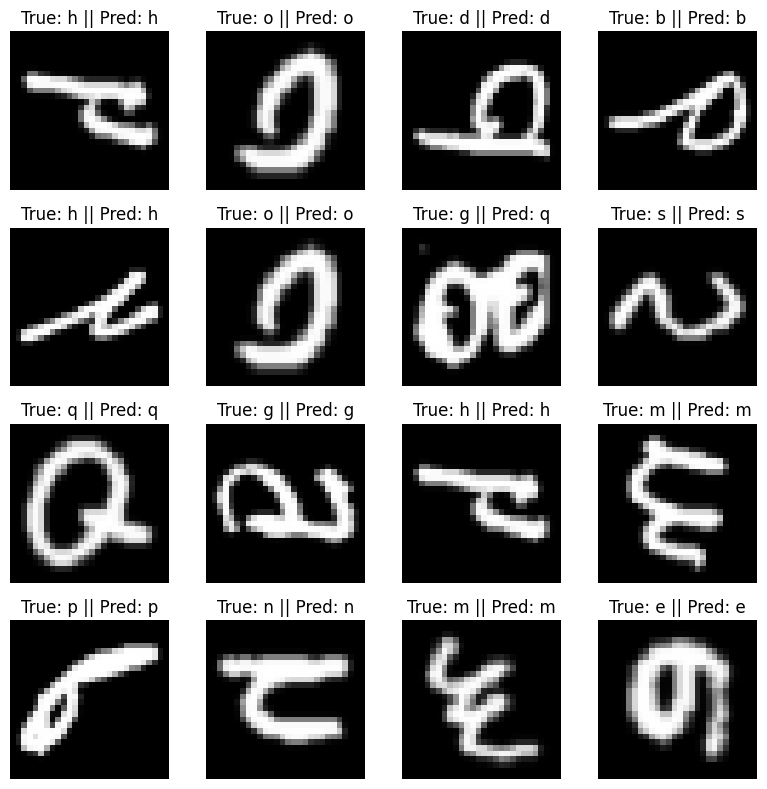

In [69]:
fig = plt.figure(figsize = (8, 8))

for i, idx in enumerate(test_samples):
    true_label = classes[int(test_labels[idx].item()) - 1]
    pred_label = classes[np.argmax(predictions[idx])]
    
    plt.subplot(4, 4, i+1)
    plt.imshow(test_images[idx] / 255.0, cmap="gray")
    plt.title(f"True: {true_label} || Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Confusion

In [82]:
y_pred = []
y_true = []

In [83]:
for inputs, labels in test_dl:
    output = loaded_model.predict(inputs.numpy())

    output = np.argmax(output, axis=1).astype('float64').tolist()
    y_pred.extend(output)

    labels = [x-1 for x in labels.tolist()]
    y_true.extend(labels)

In [84]:
acc = accuracy_score(y_true, y_pred)
acc

0.8519594594594595

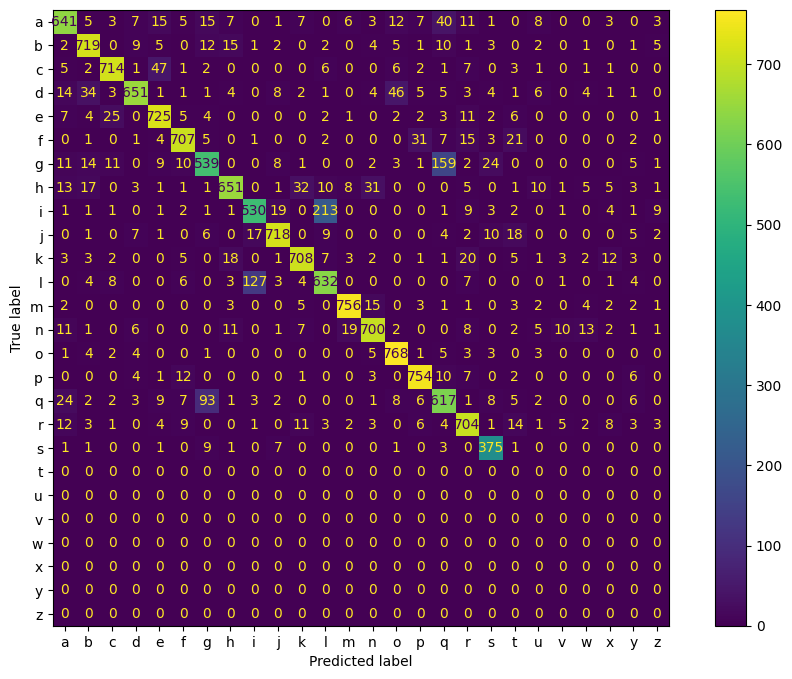

In [86]:
cm = confusion_matrix(y_true, y_pred)
confusion = ConfusionMatrixDisplay(cm, display_labels=classes)

fig, ax = plt.subplots(figsize = (12,8))
confusion.plot(ax = ax)